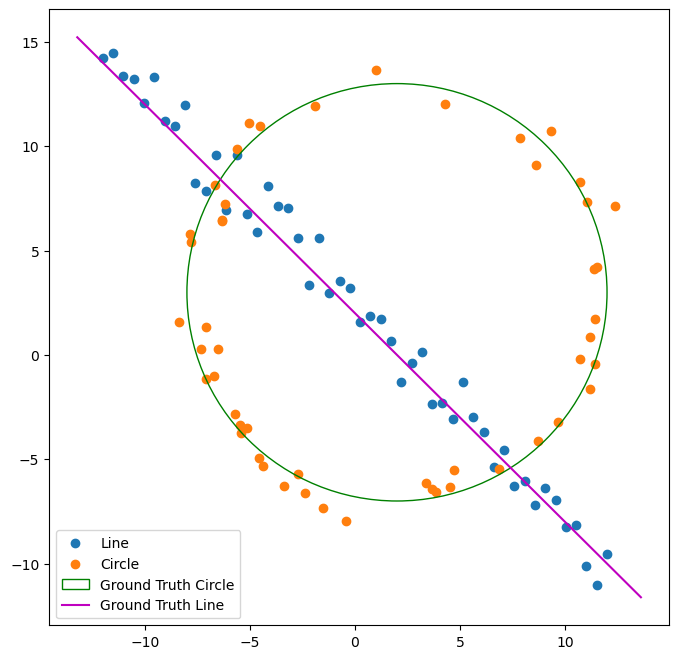

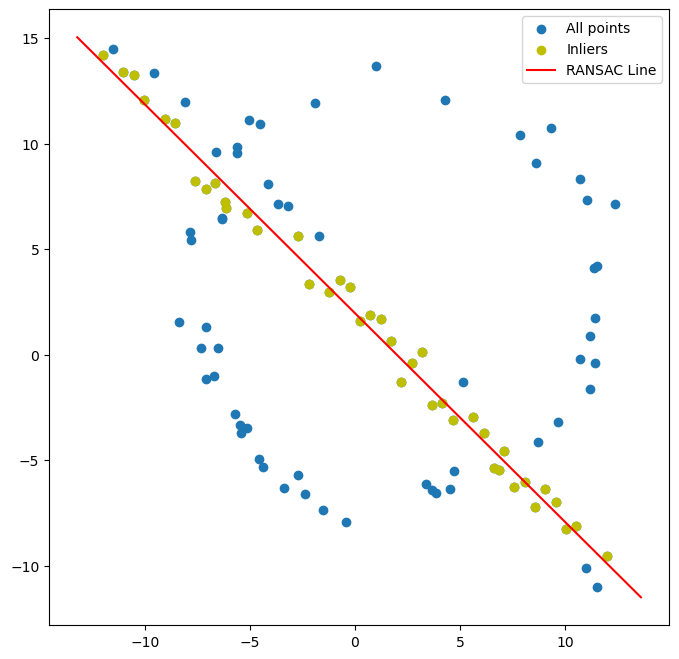

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math

# Generating noisy data for circle and line
np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth circle center
s = r / 16

# Generating noisy circle data
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x_circ, y_circ = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circ.reshape(half_n, 1), y_circ.reshape(half_n, 1)))

# Generating noisy line data
s = 1.0
m, b = -1, 2
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))

# Combine circle and line points
X = np.vstack((X_circ, X_line))

# Plot the initial point set with ground truth
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground Truth Line')
plt.legend()
plt.show()

# Define the line fitting using RANSAC and least squares
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = a * x1 + b * y1
    return a, b, d

def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X[indices, 0] + b * X[indices, 1] - d))

# Constraint for normalizing the direction vector
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# RANSAC parameters
t = 1  # Threshold for error
d = 0.4 * N  # Number of points needed for consensus
s = 2  # Number of points to estimate the model

best_model_line = []
best_inliers_line = []
best_error = np.inf
iteration = 0
max_iterations = 50

while iteration < max_iterations:
    indices = np.random.randint(0, N, s)
    x0 = np.array([1, 1, 0])  # Initial guess
    res = minimize(fun=line_tls, args=(indices), x0=x0, tol=1e-6, constraints=cons)
    inliers_line = np.abs(res.x[0] * X[:, 0] + res.x[1] * X[:, 1] - res.x[2]) < t
    if inliers_line.sum() > d:
        res = minimize(fun=line_tls, args=(inliers_line), x0=res.x, tol=1e-6, constraints=cons)
        if res.fun < best_error:
            best_model_line = res.x
            best_error = res.fun
            best_inliers_line = inliers_line
    iteration += 1

# Plot the RANSAC line result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Inliers')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0] * x_ + best_model_line[2]) / best_model_line[1]
plt.plot(x_, y_, color='r', label='RANSAC Line')
plt.legend()
plt.show()


C:\Users\thami\AppData\Local\Temp\ipykernel_12752\4198636401.py:9: RuntimeWarning: invalid value encountered in scalar divide
  ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
C:\Users\thami\AppData\Local\Temp\ipykernel_12752\4198636401.py:10: RuntimeWarning: invalid value encountered in scalar divide
  uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d


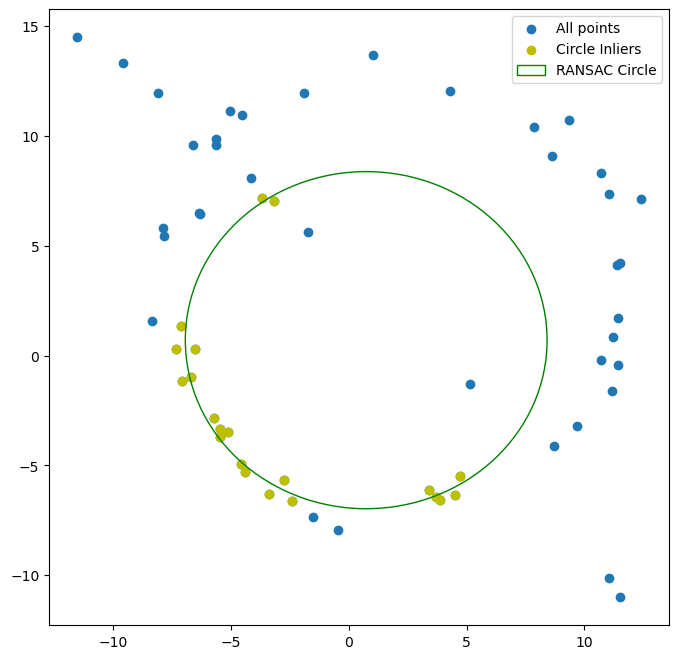

In [3]:
# Remove line inliers
inlier_indices = np.where(best_inliers_line)[0]
remnant_indices = np.setdiff1d(np.arange(N), inlier_indices)
X_ = X[remnant_indices]
N_remnant = X_.shape[0]

def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
    uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d
    r = np.sqrt((ux - x1)**2 + (uy - y1)**2)
    return ux, uy, r

def circle_tls(x, indices):
    ux, uy, r = x[0], x[1], x[2]
    return np.sum(np.square(np.sqrt((X_[indices, 0] - ux)**2 + (X_[indices, 1] - uy)**2) - r))

# RANSAC parameters for circle
t_circle = 1.0
d_circle = 0.3 * N_remnant
s_circle = 3
best_model_circle = []
best_inliers_circle = []
best_error_circle = np.inf
max_iterations_circle = 50
iteration_circle = 0

while iteration_circle < max_iterations_circle:
    indices_circle = np.random.randint(0, N_remnant, s_circle)
    x0_circle = circle_equation_from_points(X_[indices_circle[0], 0], X_[indices_circle[0], 1],
                                            X_[indices_circle[1], 0], X_[indices_circle[1], 1],
                                            X_[indices_circle[2], 0], X_[indices_circle[2], 1])
    res_circle = minimize(fun=circle_tls, args=(indices_circle), x0=x0_circle, tol=1e-6)
    inliers_circle = np.abs(np.sqrt((X_[:, 0] - res_circle.x[0])**2 + (X_[:, 1] - res_circle.x[1])**2) - res_circle.x[2]) < t_circle
    if inliers_circle.sum() > d_circle:
        res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=res_circle.x, tol=1e-6)
        if res_circle.fun < best_error_circle:
            best_model_circle = res_circle.x
            best_error_circle = res_circle.fun
            best_inliers_circle = inliers_circle
    iteration_circle += 1

# Plot the RANSAC circle result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_[:, 0], X_[:, 1], label='All points')
ax.scatter(X_[best_inliers_circle, 0], X_[best_inliers_circle, 1], color='y', label='Circle Inliers')
circle_ransac = plt.Circle((best_model_circle[0], best_model_circle[1]), best_model_circle[2], color='g', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)
plt.legend()
plt.show()


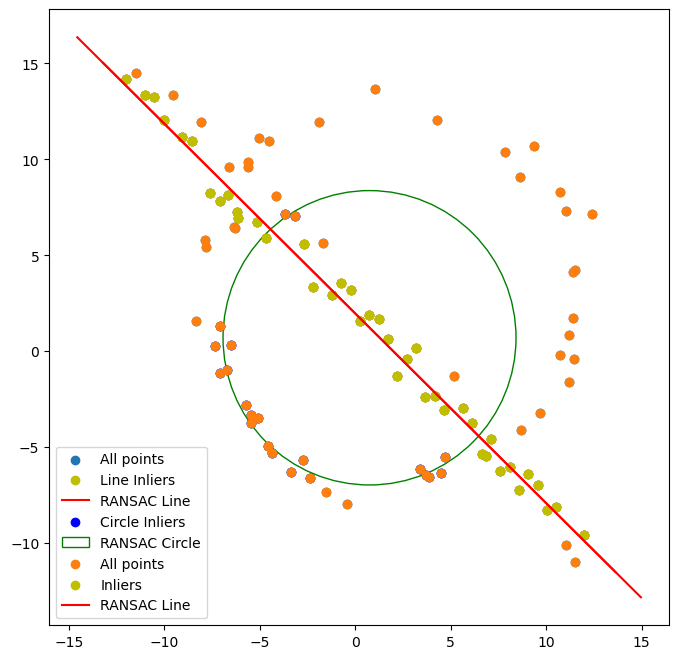

In [4]:
# Combined plot for line and circle RANSAC results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], label='All points')

# Plot line inliers
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')

# Plot RANSAC line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0] * x_ + best_model_line[2]) / best_model_line[1]
plt.plot(x_, y_, color='r', label='RANSAC Line')

# Plot circle inliers
ax.scatter(X_[best_inliers_circle, 0], X_[best_inliers_circle, 1], color='b', label='Circle Inliers')

# Plot RANSAC circle
circle_ransac = plt.Circle((best_model_circle[0], best_model_circle[1]), best_model_circle[2], color='g', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)
#---------------------------
# Plot the RANSAC line result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Inliers')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[0] * x_ + best_model_line[2]) / best_model_line[1]
plt.plot(x_, y_, color='r', label='RANSAC Line')
#-----------------------
plt.legend()
plt.show()
